<a href="https://colab.research.google.com/github/BetulGull/BrainTumorClassification/blob/main/braintumor22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("GPU in use:", tf.config.list_physical_devices('GPU'))


GPU in use: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
def load_data(data_dir, image_size=(150, 150)):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for idx, folder in enumerate(class_names):
        folder_path = os.path.join(data_dir, folder)
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            try:
                img = Image.open(img_path).resize(image_size).convert('RGB')
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Skipped: {img_path} — Reason: {e}")

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(class_names))
    return images, labels, class_names

In [ ]:

train_dir = "/content/drive/MyDrive/ai/ai/Training"
test_dir = "/content/drive/MyDrive/ai/ai/Testing"

X_train, y_train, class_names = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Classes:", class_names)



Training samples: 5807
Testing samples: 1331
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# TRAINING
train_class_counts = dict(zip(class_names, np.sum(y_train, axis=0)))
print("🔹 Training samples per class:")
for cls, count in train_class_counts.items():
    print(f"{cls}: {int(count)}")

# TESTING
test_class_counts = dict(zip(class_names, np.sum(y_test, axis=0)))
print("\n🔹 Testing samples per class:")
for cls, count in test_class_counts.items():
    print(f"{cls}: {int(count)}")


🔹 Training samples per class:
glioma: 1331
meningioma: 1379
notumor: 1640
pituitary: 1457

🔹 Testing samples per class:
glioma: 310
meningioma: 316
notumor: 405
pituitary: 300


In [ ]:
from tensorflow.keras import layers, models, callbacks

def build_cnn_model(input_shape=(64, 64, 3), num_classes=4):
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # ← Overfitting protection

    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # ← Heavier Dropout here
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()
    return model

In [ ]:

model = build_cnn_model(input_shape=(150, 150, 3), num_classes=len(class_names))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ⏹️ Optional: Stop training if val_loss gets worse
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,764 (18.42 MB)

 Trainable params: 4,829,316 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])



Epoch 1/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8151 - loss: 0.4474 - val_accuracy: 0.7739 - val_loss: 0.5655
Epoch 2/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8012 - loss: 0.4531 - val_accuracy: 0.7077 - val_loss: 0.6431
Epoch 3/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8306 - loss: 0.4447 - val_accuracy: 0.8272 - val_loss: 0.4322
Epoch 4/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8290 - loss: 0.4108 - val_accuracy: 0.8708 - val_loss: 0.3017
Epoch 5/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8558 - loss: 0.3560 - val_accuracy: 0.8174 - val_loss: 0.6245
Epoch 6/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8463 - loss: 0.3599 - val_accuracy: 0.8618 - val_loss: 0.3255
Epoch 7/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8818 - loss: 0.3043 - val_accuracy: 0.8866 - val_loss: 0.2930
Epoch 8/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8746 - loss: 0.2838 - val

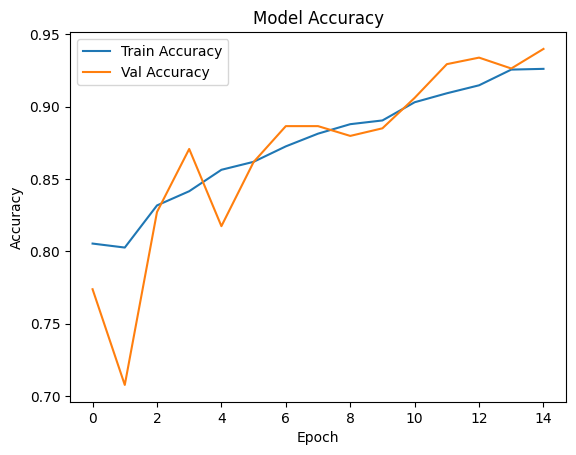

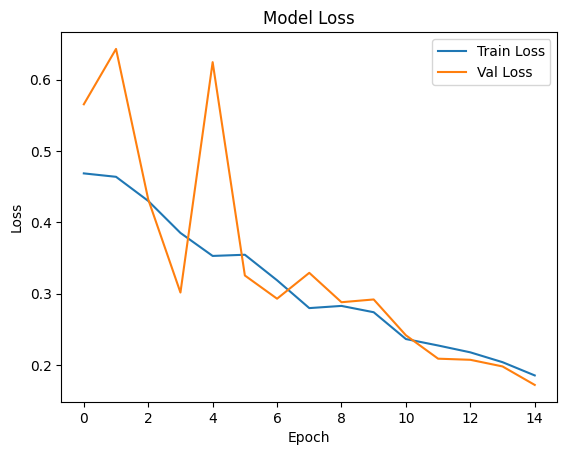

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9147 - loss: 0.2283
Test accuracy: 0.9399, Test loss: 0.1722


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


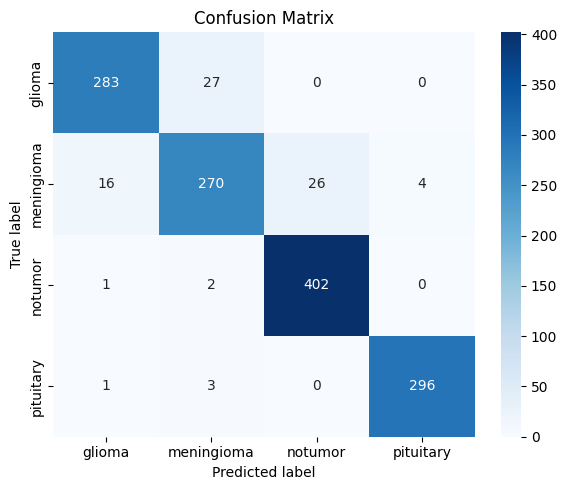

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9402    0.9129    0.9264       310
  meningioma     0.8940    0.8544    0.8738       316
     notumor     0.9393    0.9926    0.9652       405
   pituitary     0.9867    0.9867    0.9867       300

    accuracy                         0.9399      1331
   macro avg     0.9400    0.9366    0.9380      1331
weighted avg     0.9394    0.9399    0.9393      1331


Macro Avg Precision: 0.9400
Macro Avg Recall:    0.9366
Macro Avg F1-score:  0.9380

Weighted Avg Precision: 0.9394
Weighted Avg Recall:    0.9399
Weighted Avg F1-score:  0.9393


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_pred         = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,  axis=1)
y_true         = np.argmax(y_test,  axis=1)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


report_txt  = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
)
print("Classification Report:\n")
print(report_txt)


report_dict = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    output_dict=True
)

macro_p  = report_dict['macro avg']['precision']
macro_r  = report_dict['macro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']

weighted_p  = report_dict['weighted avg']['precision']
weighted_r  = report_dict['weighted avg']['recall']
weighted_f1 = report_dict['weighted avg']['f1-score']

print(f"\nMacro Avg Precision: {macro_p:.4f}")
print(f"Macro Avg Recall:    {macro_r:.4f}")
print(f"Macro Avg F1-score:  {macro_f1:.4f}\n")

print(f"Weighted Avg Precision: {weighted_p:.4f}")
print(f"Weighted Avg Recall:    {weighted_r:.4f}")
print(f"Weighted Avg F1-score:  {weighted_f1:.4f}")



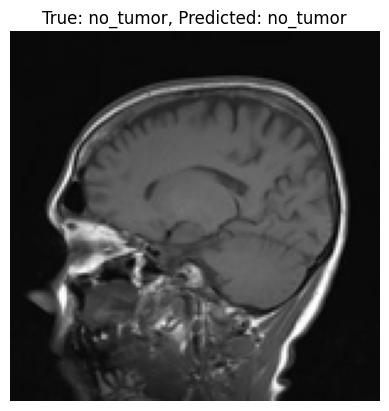

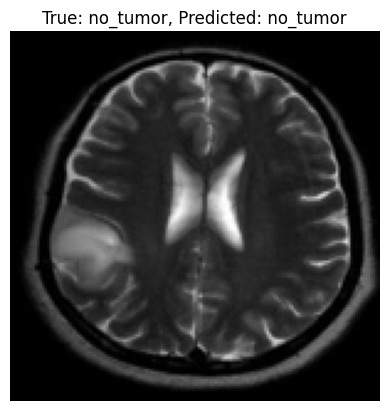

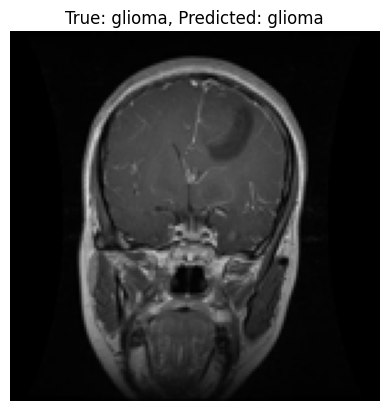

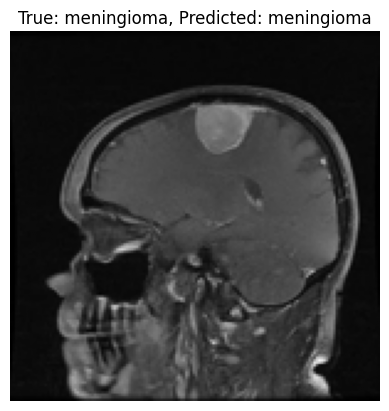

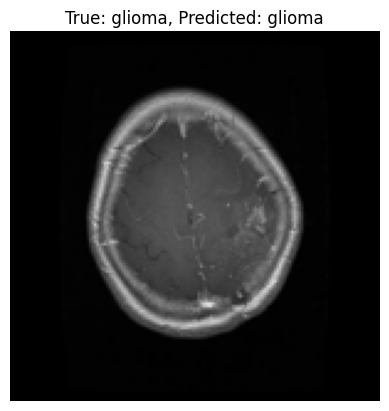

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define class names in the same order as they appear in your labels
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Pick 3 random test images
indices = random.sample(range(len(X_test)), 5)

for i in indices:
    img = X_test[i]
    true_label = np.argmax(y_test[i])

    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label = np.argmax(pred)

    # Plot
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

def build_transfer_learning_model(input_shape=(150, 150, 3), num_classes=4):
    # Load pre-trained VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.summary()
    return model, base_model

In [ ]:
# Create transfer learning model
transfer_model, base_model = build_transfer_learning_model(input_shape=(150, 150, 3),
                                                          num_classes=len(class_names))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,124 (64.14 MB)

 Trainable params: 2,098,436 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


In [ ]:
# Train the model with frozen base layers
print("Starting initial training with frozen base layers...")
transfer_history_initial = transfer_model.fit(X_train, y_train,
                                             epochs=15,  # Fewer epochs for initial training
                                             batch_size=32,
                                             validation_data=(X_test, y_test),
                                             callbacks=[early_stop])


Starting initial training with frozen base layers...
Epoch 1/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 47s 193ms/step - accuracy: 0.6974 - loss: 0.8813 - val_accuracy: 0.8392 - val_loss: 0.3922
Epoch 2/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.8705 - loss: 0.3491 - val_accuracy: 0.8490 - val_loss: 0.3573
Epoch 3/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.8842 - loss: 0.3078 - val_accuracy: 0.8715 - val_loss: 0.3121
Epoch 4/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.8913 - loss: 0.2740 - val_accuracy: 0.8926 - val_loss: 0.2616
Epoch 5/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.9152 - loss: 0.2194 - val_accuracy: 0.8911 - val_loss: 0.2749
Epoch 6/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9290 - loss: 0.2000 - val_accuracy: 0.9219 - val_loss: 0.2153
Epoch 7/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.9379 - loss: 0.1845 - val_accuracy: 0.8993 - val_loss: 0.2414
Epoch 8/15
182/182 ━━━━━━━━━━━

In [ ]:
# Fine-tuning step: Unfreeze some layers of the base model
print("\n==== FINE-TUNING TRANSFER LEARNING MODEL ====")
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True


==== FINE-TUNING TRANSFER LEARNING MODEL ====


In [ ]:
# Recompile with lower learning rate
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Continue training with fine-tuning
print("Starting fine-tuning...")
transfer_history_fine_tune = transfer_model.fit(X_train, y_train,
                                               epochs=4,  # Just a few epochs for fine-tuning
                                               batch_size=32,
                                               validation_data=(X_test, y_test),
                                               callbacks=[early_stop])


Starting fine-tuning...
Epoch 1/4
182/182 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.9663 - loss: 0.0968 - val_accuracy: 0.9339 - val_loss: 0.1982
Epoch 2/4
182/182 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.9704 - loss: 0.0880 - val_accuracy: 0.9572 - val_loss: 0.1185
Epoch 3/4
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9780 - loss: 0.0550 - val_accuracy: 0.9677 - val_loss: 0.0896
Epoch 4/4
182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.9910 - loss: 0.0387 - val_accuracy: 0.9459 - val_loss: 0.1676


In [ ]:
# Save the transfer learning model
transfer_model.save('/content/drive/MyDrive/ai/transfer_learning_model.h5')
print("Transfer Learning model saved!")

Transfer Learning model saved!


In [ ]:
# Combine the training histories
def plot_combined_history(initial_history, fine_tune_history):
    acc = initial_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy']
    loss = initial_history.history['loss']
    val_loss = initial_history.history['val_loss']

    # Add fine-tuning history
    acc += fine_tune_history.history['accuracy']
    val_acc += fine_tune_history.history['val_accuracy']
    loss += fine_tune_history.history['loss']
    val_loss += fine_tune_history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.axvline(x=len(initial_history.history['accuracy']), color='r', linestyle='--')
    plt.text(len(initial_history.history['accuracy']), 0.5, 'Start Fine Tuning', rotation=90)
    plt.title('Transfer Learning Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.axvline(x=len(initial_history.history['loss']), color='r', linestyle='--')
    plt.text(len(initial_history.history['loss']), 0.5, 'Start Fine Tuning', rotation=90)
    plt.title('Transfer Learning Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

<ipython-input-28-cf07e0f84a22>:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


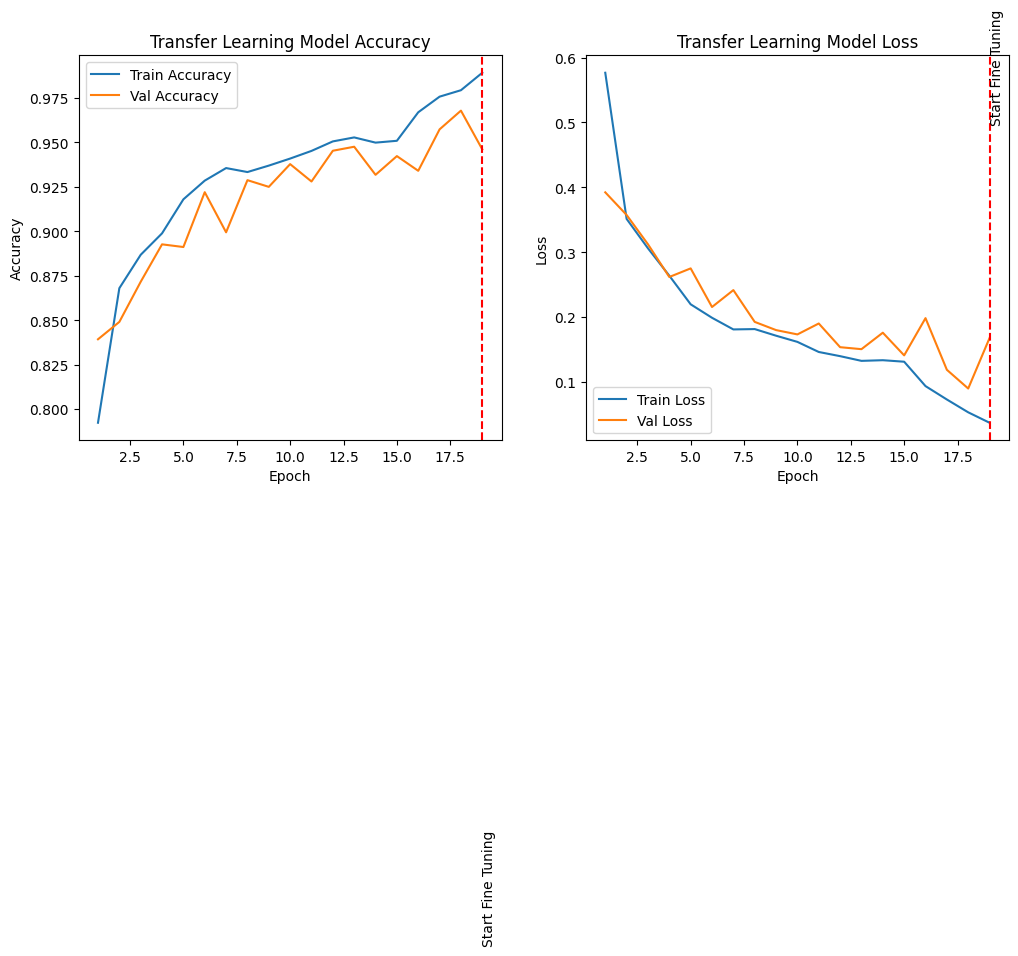

In [ ]:
# Visualize combined training history
plot_combined_history(transfer_history_initial, transfer_history_fine_tune)

In [ ]:
# Evaluate the transfer learning model
transfer_test_loss, transfer_test_acc = transfer_model.evaluate(X_test, y_test)
print(f"Transfer Learning - Test accuracy: {transfer_test_acc:.4f}, Test loss: {transfer_test_loss:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9468 - loss: 0.1350
Transfer Learning - Test accuracy: 0.9677, Test loss: 0.0896


In [ ]:
# Calculate performance metrics for transfer learning model
transfer_y_pred = transfer_model.predict(X_test)
transfer_y_pred_classes = np.argmax(transfer_y_pred, axis=1)

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step


Transfer Learning - Test accuracy: 0.9677, Test loss: 0.0896


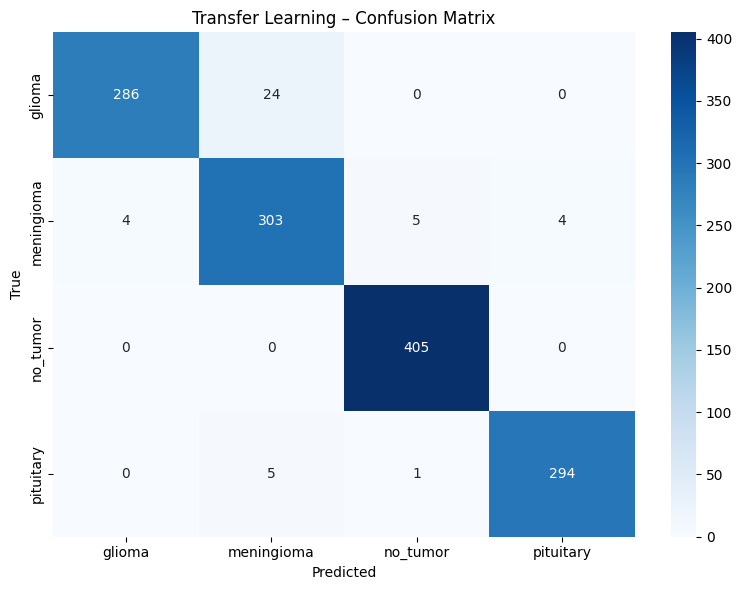

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9862    0.9226    0.9533       310
  meningioma     0.9127    0.9589    0.9352       316
    no_tumor     0.9854    1.0000    0.9926       405
   pituitary     0.9866    0.9800    0.9833       300

    accuracy                         0.9677      1331
   macro avg     0.9677    0.9654    0.9661      1331
weighted avg     0.9686    0.9677    0.9677      1331

Macro Avg Precision: 0.9677
Macro Avg Recall:    0.9654
Macro Avg F1-score:  0.9661

Weighted Avg Precision: 0.9686
Weighted Avg Recall:    0.9677
Weighted Avg F1-score:  0.9677


In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

transfer_test_loss, transfer_test_acc = transfer_model.evaluate(X_test, y_test, verbose=0)
print(f"Transfer Learning - Test accuracy: {transfer_test_acc:.4f}, "
      f"Test loss: {transfer_test_loss:.4f}")

transfer_y_pred         = transfer_model.predict(X_test, verbose=0)
transfer_y_pred_classes = np.argmax(transfer_y_pred, axis=1)

transfer_cm = confusion_matrix(y_true, transfer_y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    transfer_cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Transfer Learning – Confusion Matrix")
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(
    classification_report(
        y_true,
        transfer_y_pred_classes,
        target_names=class_names,
        digits=4
    )
)

report_dict = classification_report(
    y_true,
    transfer_y_pred_classes,
    target_names=class_names,
    output_dict=True
)

macro_p, macro_r, macro_f1 = (report_dict['macro avg'][k]     for k in ('precision', 'recall', 'f1-score'))
wght_p , wght_r , wght_f1  = (report_dict['weighted avg'][k]  for k in ('precision', 'recall', 'f1-score'))

print(f"Macro Avg Precision: {macro_p:.4f}")
print(f"Macro Avg Recall:    {macro_r:.4f}")
print(f"Macro Avg F1-score:  {macro_f1:.4f}\n")

print(f"Weighted Avg Precision: {wght_p:.4f}")
print(f"Weighted Avg Recall:    {wght_r:.4f}")
print(f"Weighted Avg F1-score:  {wght_f1:.4f}")




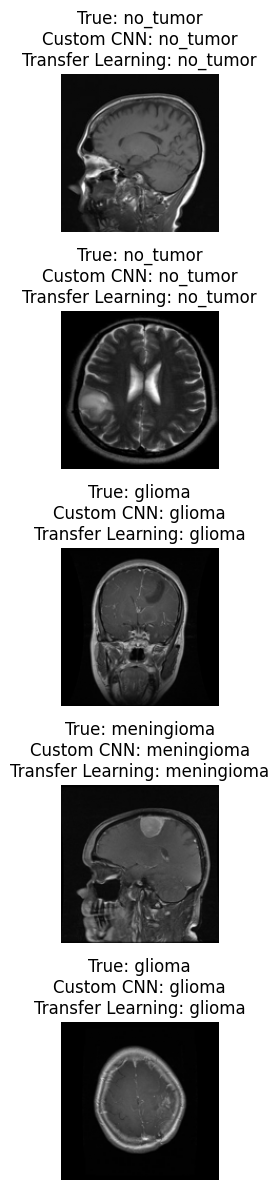

In [ ]:
plt.figure(figsize=(15, 12))  # Taller figure for 5 rows
for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = np.argmax(y_test[idx])

    # Predict with custom CNN
    cnn_pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    cnn_pred_label = np.argmax(cnn_pred)

    # Predict with transfer learning model
    transfer_pred = transfer_model.predict(np.expand_dims(img, axis=0), verbose=0)
    transfer_pred_label = np.argmax(transfer_pred)

    # Plot in a 5x1 grid
    plt.subplot(5, 1, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}\nCustom CNN: {class_names[cnn_pred_label]}\nTransfer Learning: {class_names[transfer_pred_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
